In [1]:
%pylab inline
import h5py

Populating the interactive namespace from numpy and matplotlib


In [2]:
f_train = h5py.File('train.h5','r')
f_test = h5py.File('test.h5','r')

In [3]:
print(f_train.keys())
print(f_test.keys())

[u'train']
[u'test']


In [4]:
a_train = f_train['train']
a_test = f_test['test']

In [5]:
print(a_train.keys())
print(a_test.keys())

[u'axis0', u'axis1', u'block0_items', u'block0_values', u'block1_items', u'block1_values']
[u'axis0', u'axis1', u'block0_items', u'block0_values']


In [6]:
b = a_test['axis1']

In [7]:
b.shape

(8137,)

In [8]:
# axis0 -> Labels [shape (101,)]
# axis1 -> id column [shape (45324,)]
# block0_items -> traits labels [shape (100,)]
# block0_values -> traits values [shape (45324,100)]
# block1_items -> 'y' label
# block1_values -> y column (without label) [shape (45324,1)]

In [9]:
X_train = a_train['block0_values'][()]
y_train = a_train['block1_values'][()]
y_train = y_train[:,0]
X_test = a_test['block0_values'][()]
X_train, X_val = X_train[:-1000], X_train[-1000:]
y_train, y_val = y_train[:-1000], y_train[-1000:]
ids = a_test['axis1']

In [10]:
print(X_train.shape)
print(type(X_train))

(44324, 100)
<type 'numpy.ndarray'>


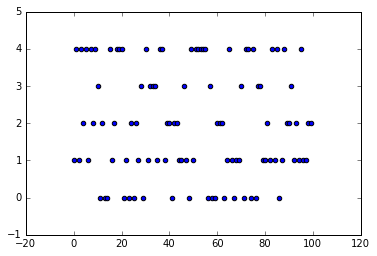

In [11]:
scatter(arange(100), y_train[0:100])

In [15]:
s = ''
z = 0
for i in arange(100):
    for j in arange(100):
        if b[i,j]==0.:
            z=z+1
        s += str(b[i,j]) + ' '
    s += '/n'

In [16]:
print(str(z/100.) + '% percentage of zeros in chunk of matrix')

78.1% percentage of zeros in chunk of matrix


In [12]:
from theano import *
import theano.tensor as T

In [13]:
x = T.dvector('x') # declare variable
y = T.dvector('y')
out = y.dot(y) + x.dot(x)         # build symbolic expression
fun = theano.function([x,y], out)   # compile function
print(fun([2,1],[1,1]))

7.0


# Neural Network: Lasagne

In [14]:
from __future__ import print_function
import time
import lasagne

/Users/Camilo/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [15]:
def build_custom_mlp(input_var=None, depth=2, width=800, drop_input=.2,
                     drop_hidden=.5):
    # By default, this creates the same network as `build_mlp`, but it can be
    # customized with respect to the number and size of hidden layers. This
    # mostly showcases how creating a network in Python code can be a lot more
    # flexible than a configuration file. Note that to make the code easier,
    # all the layers are just called `network` -- there is no need to give them
    # different names if all we return is the last one we created anyway; we
    # just used different names above for clarity.

    # Input layer and dropout (with shortcut `dropout` for `DropoutLayer`):
    network = lasagne.layers.InputLayer(shape=(None, 100),
                                        input_var=input_var)
    if drop_input:
        network = lasagne.layers.dropout(network, p=drop_input)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.rectify
    for _ in range(depth):
        network = lasagne.layers.DenseLayer(network, width, nonlinearity=nonlin)
        if drop_hidden:
            network = lasagne.layers.dropout(network, p=drop_hidden)
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(network, 5, nonlinearity=softmax)
    return network

In [16]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [17]:
def train_nnet(num_epochs=500):
    # Load the dataset
    # print("Loading data...")
    # X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
    
    # theano.config.optimizer='fast_compile'
    # theano.config.exception_verbosity='high'

    # Prepare Theano variables for inputs and targets
    input_var = T.matrix('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    
    network = build_custom_mlp(input_var=input_var,depth=2,width=1000,drop_input=.3,drop_hidden=.5)

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.1, momentum=0.8)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,target_var)
    test_loss = test_loss.mean()
    
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc], allow_input_downcast=True)

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    global percs
    percs = array([])
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        
        for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        perc = val_acc / val_batches
        percs = append(percs, perc)
        print("  validation accuracy:\t\t{:.2f} %".format(
            perc * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, zeros(len(X_test)), 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))
    global result
    result = lasagne.layers.get_output(network, X_test)

In [18]:
train_nnet(num_epochs=20)

Building model and compiling functions...
Starting training...
Epoch 1 of 20 took 17.201s
  training loss:		0.910129
  validation loss:		0.473334
  validation accuracy:		85.10 %
Epoch 2 of 20 took 16.000s
  training loss:		0.651152
  validation loss:		0.371750
  validation accuracy:		88.10 %
Epoch 3 of 20 took 15.549s
  training loss:		0.577208
  validation loss:		0.332465
  validation accuracy:		89.40 %
Epoch 4 of 20 took 15.444s
  training loss:		0.531923
  validation loss:		0.298115
  validation accuracy:		90.20 %
Epoch 5 of 20 took 15.675s
  training loss:		0.503946
  validation loss:		0.278973
  validation accuracy:		91.40 %
Epoch 6 of 20 took 15.650s
  training loss:		0.486745
  validation loss:		0.277478
  validation accuracy:		91.40 %
Epoch 7 of 20 took 15.657s
  training loss:		0.476122
  validation loss:		0.255260
  validation accuracy:		92.50 %
Epoch 8 of 20 took 15.401s
  training loss:		0.454511
  validation loss:		0.243681
  validation accuracy:		92.40 %
Epoch 9 of 20 too

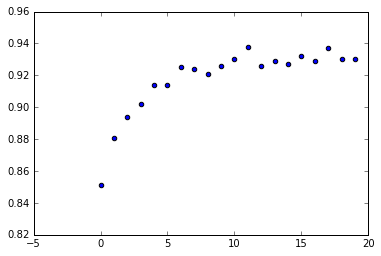

In [19]:
scatter(arange(len(percs)),percs)

In [21]:
final = result.eval()
final

array([[  3.18216351e-03,   2.23474139e-02,   4.50536699e-02,
          2.95644512e-03,   9.26460308e-01],
       [  1.21483342e-01,   8.51775788e-03,   1.29975228e-01,
          3.72959250e-01,   3.67064422e-01],
       [  3.95705044e-01,   4.60606726e-01,   2.13350668e-02,
          6.33180164e-02,   5.90351466e-02],
       ..., 
       [  9.99949351e-01,   3.44554606e-05,   2.93492469e-06,
          1.26010328e-05,   6.57124163e-07],
       [  9.95113945e-01,   4.40167075e-05,   4.56171035e-04,
          7.07840554e-04,   3.67802660e-03],
       [  1.37977142e-02,   8.00849838e-04,   9.74504435e-01,
          8.21589474e-03,   2.68110659e-03]])

In [22]:
sum(final[0,:])

1.0

In [23]:
y_output = list([])
for i in arange(len(final)):
    my_list = final[i,:]
    max_index = my_list.argmax()
    y_output.append(max_index)

In [24]:
len(y_output)

8137

In [25]:
y_output

[4,
 3,
 1,
 3,
 1,
 0,
 3,
 4,
 3,
 1,
 1,
 1,
 4,
 3,
 4,
 1,
 2,
 3,
 0,
 1,
 0,
 4,
 0,
 2,
 4,
 0,
 4,
 4,
 4,
 4,
 1,
 2,
 2,
 3,
 4,
 2,
 3,
 0,
 3,
 4,
 2,
 3,
 1,
 3,
 4,
 2,
 0,
 0,
 2,
 4,
 1,
 2,
 1,
 1,
 0,
 4,
 3,
 0,
 3,
 4,
 2,
 0,
 2,
 0,
 3,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 3,
 4,
 3,
 3,
 3,
 2,
 3,
 1,
 1,
 1,
 2,
 3,
 1,
 2,
 1,
 4,
 4,
 1,
 0,
 0,
 4,
 3,
 3,
 3,
 3,
 1,
 2,
 2,
 2,
 3,
 0,
 0,
 0,
 0,
 1,
 4,
 2,
 2,
 2,
 4,
 3,
 2,
 3,
 3,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 3,
 1,
 1,
 0,
 2,
 4,
 4,
 0,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 0,
 3,
 2,
 0,
 3,
 1,
 2,
 1,
 0,
 0,
 1,
 3,
 0,
 2,
 1,
 2,
 1,
 0,
 0,
 0,
 3,
 3,
 0,
 0,
 2,
 1,
 2,
 4,
 0,
 0,
 1,
 3,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 2,
 0,
 3,
 0,
 1,
 2,
 4,
 1,
 3,
 2,
 2,
 3,
 0,
 2,
 0,
 1,
 4,
 1,
 4,
 3,
 1,
 3,
 2,
 3,
 3,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 3,
 3,
 1,
 3,
 0,
 3,
 2,
 0,
 3,
 2,
 2,
 1,
 2,
 4,
 2,
 1,
 2,
 4,
 4,
 2,
 2,
 3,
 1,
 3,
 4,
 3,
 2,
 1,
 2,
 3,
 2,
 0,
 1,
 3,
 3,
 0,
 0,
 0,


In [26]:
import csv
with open('result1.csv', 'wb') as fp:
    a = csv.writer(fp, delimiter=',')
    a.writerow(('Id','y'))
    a.writerows(zip(ids,y_output))

# Convolutional Neural Networks

In [20]:
X_train_c = X_train.reshape(len(X_train),1,10,10)
X_val_c = X_val.reshape(len(X_val),1,10,10)
X_test_c = X_test.reshape(len(X_test),1,10,10) 
X_test_c.shape

(8137, 1, 10, 10)

In [21]:
def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, 10, 10),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(3, 3),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(3, 3),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.4),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.4),
            num_units=5,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [29]:
def train_cnn(num_epochs=500):
    # Load the dataset
    # print("Loading data...")
    # X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
    
    # theano.config.optimizer='fast_compile'
    # theano.config.exception_verbosity='high'

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    
    network = build_cnn(input_var=input_var)

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.006, momentum=0.8)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,target_var)
    test_loss = test_loss.mean()
    
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc], allow_input_downcast=True)

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    global percs2
    percs2 = array([])
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        
        for batch in iterate_minibatches(X_train_c, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val_c, y_val, 500, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        perc = val_acc/val_batches
        percs2 = append(percs2,perc)
        print("  validation accuracy:\t\t{:.2f} %".format(
            perc * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test_c, zeros(len(X_test_c)), 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))
    global result2
    result2 = lasagne.layers.get_output(network, X_test_c)

In [30]:
train_cnn(num_epochs=200)

Building model and compiling functions...
Starting training...
Epoch 1 of 200 took 8.104s
  training loss:		1.605329
  validation loss:		1.595370
  validation accuracy:		35.10 %
Epoch 2 of 200 took 9.128s
  training loss:		1.594809
  validation loss:		1.580480
  validation accuracy:		37.00 %
Epoch 3 of 200 took 8.630s
  training loss:		1.579551
  validation loss:		1.556551
  validation accuracy:		43.30 %
Epoch 4 of 200 took 8.000s
  training loss:		1.555958
  validation loss:		1.517005
  validation accuracy:		48.60 %
Epoch 5 of 200 took 8.021s
  training loss:		1.515565
  validation loss:		1.453244
  validation accuracy:		54.20 %
Epoch 6 of 200 took 8.042s
  training loss:		1.454881
  validation loss:		1.359869
  validation accuracy:		55.50 %
Epoch 7 of 200 took 8.086s
  training loss:		1.373174
  validation loss:		1.246869
  validation accuracy:		60.30 %
Epoch 8 of 200 took 8.039s
  training loss:		1.280525
  validation loss:		1.128536
  validation accuracy:		64.50 %
Epoch 9 of 200 to

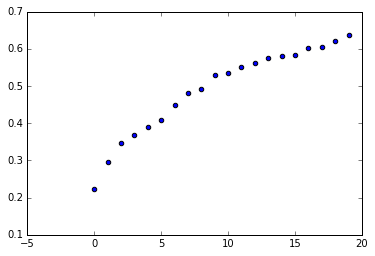

In [27]:
scatter(arange(len(percs2)),percs2)